In [1]:

#load the libraries
library(lme4)
library(nlme)
library(arm)
library(RCurl)#to directly download the rikz dataset

########################
# part 0 fitting GLMM #
 #  #  #  #  #  #  # 

#the example dataset we will use
rikz_link<-getURL("https://raw.githubusercontent.com/ranalytics/r-tutorials/master/Edition_2015/Data/RIKZ.txt")
data<-read.table(textConnection(rikz_link),head=TRUE,sep="\t",stringsAsFactors = FALSE)
#first a random intercept model
mod_lme1<-lme(Richness~NAP,data=data,random=~1|Beach)
mod_lmer1<-lmer(Richness~NAP+(1|Beach),data=data)
#then a random slope plus intercept model
# mod_lme2<-lme(Richness~NAP,data=data,random=NAP|Beach)
mod_lmer2<-lmer(Richness~NAP+(NAP|Beach),data=data)
# #Poisson model
# mod_glmer1<-glmer(Richness~NAP+(1|Beach),data=data,family="poisson")
# #nested and crossed random effect??

Loading required package: Matrix

Attaching package: ‘nlme’

The following object is masked from ‘package:lme4’:

    lmList

Loading required package: MASS

arm (Version 1.11-1, built: 2020-4-27)

Working directory is /home/ec2-user/mhw_stressviz/analysis

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00267151 (tol = 0.002, component 1)”

In [24]:
#factor variable with intercept only effect
#simulate data in a fixed effect way
x<-rnorm(120,0,1)
f<-gl(n=6,k=20)
modmat<-model.matrix(~x+f,data.frame(x=x,f=f))
betas<-c(1,2,0.3,-3,0.5,1.2,0.8)
y<-modmat%*%betas+rnorm(120,0,1)

#the fixed effect model
m_lm<-lm(y~x+f)
#the mixed effect model
m_lme<-lme(y~x,random=~1|f)

In [31]:
mod_lme1

Linear mixed-effects model fit by REML
  Data: data 
  Log-restricted-likelihood: -119.7401
  Fixed: Richness ~ NAP 
(Intercept)         NAP 
   6.581893   -2.568400 

Random effects:
 Formula: ~1 | Beach
        (Intercept) Residual
StdDev:    2.944065  3.05977

Number of Observations: 45
Number of Groups: 9 

In [32]:
#testing the random effect
#a first model
mod1<-lme(Richness~NAP+Exposure,data=data,random=~1|Beach,method="REML")
#a second model without the random term, gls is used because it also fit the model through REML
mod2<-gls(Richness~NAP+Exposure,data=data,method="REML")
#likelihood ratio test, not very precise for low sample size
anova(mod1,mod2)

# parameteric bootstrap
lrt.obs <- anova(mod1, mod2)$L.Ratio[2] # save the observed likelihood ratio test statistic
n.sim <- 1000  # use 1000 for a real data analysis
lrt.sim <- numeric(n.sim)
dattemp <- data
for(i in 1:n.sim){
  dattemp$ysim <- simulate(lm(Richness ~ NAP+Exposure, data=dattemp))$sim_1 # simulate new observations from the null-model
  modnullsim <- gls(ysim ~ NAP+Exposure, data=dattemp)   # fit the null-model
  modaltsim <-lme(ysim ~ NAP+Exposure, random=~1|Beach, data=dattemp)  # fit the alternative model
  lrt.sim[i] <- anova(modnullsim, modaltsim)$L.Ratio[2] # save the likelihood ratio test statistic
}

(sum(lrt.sim>=lrt.obs)+1)/(n.sim+1)  # p-value


,call,Model,df,AIC,BIC,logLik,Test,L.Ratio,p-value
mod1,"lme.formula(fixed = Richness ~ NAP + Exposure, data = data, random = ~1 | Beach, method = ""REML"")",1,5,235.5282,244.2166,-112.7641,,NA,NA
mod2,"gls(model = Richness ~ NAP + Exposure, data = data, method = ""REML"")",2,4,233.6073,240.5580,-112.8037,1 vs 2,0.07912225,0.7784904


[1] 0.3426573

In [33]:
#testing the random effect
#a first model
mod1<-lme(Richness~NAP+Exposure,data=data,random=~1|Beach,method="REML")
#a second model without the random term, gls is used because it also fit the model through REML
mod2<-gls(Richness~NAP+Exposure,data=data,method="REML")
#likelihood ratio test, not very precise for low sample size
anova(mod1,mod2)

,call,Model,df,AIC,BIC,logLik,Test,L.Ratio,p-value
mod1,"lme.formula(fixed = Richness ~ NAP + Exposure, data = data, random = ~1 | Beach, method = ""REML"")",1,5,235.5282,244.2166,-112.7641,,NA,NA
mod2,"gls(model = Richness ~ NAP + Exposure, data = data, method = ""REML"")",2,4,233.6073,240.5580,-112.8037,1 vs 2,0.07912225,0.7784904


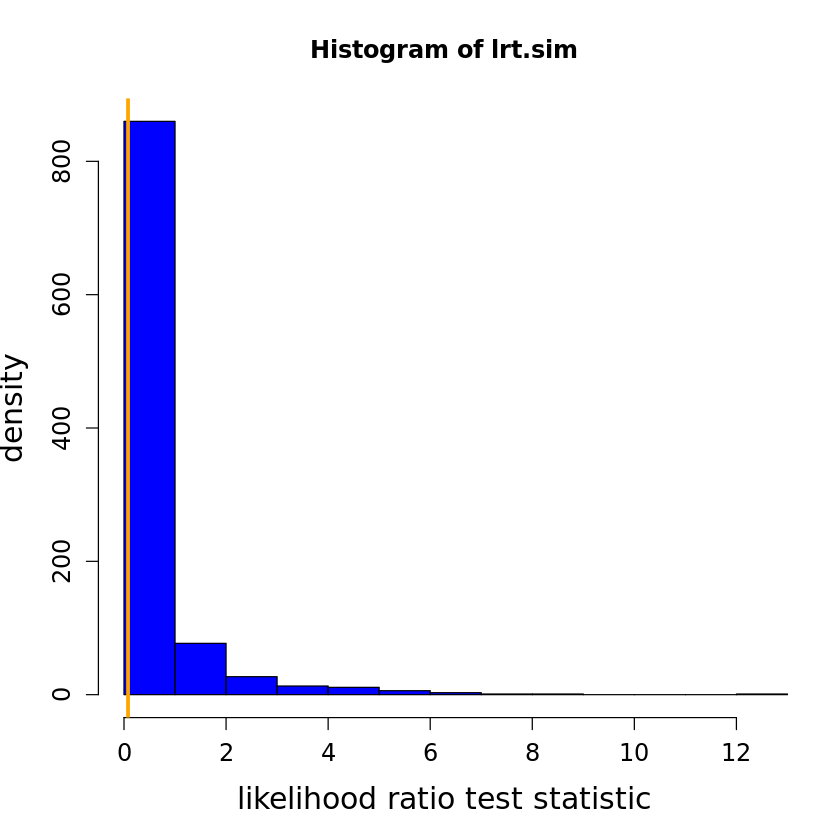

In [34]:
#plot
par(mfrow=c(1,1))
hist(lrt.sim, xlim=c(0, max(c(lrt.sim, lrt.obs))), col="blue", xlab="likelihood ratio test statistic", ylab="density", cex.lab=1.5, cex.axis=1.2)
abline(v=lrt.obs, col="orange", lwd=3)